In [264]:
import pandas as pd
import numpy as np
from math import *
import matplotlib.pyplot as plt
import datetime as dt
import scipy.stats as st
import seaborn as sns
import json
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import statsmodels.stats.stattools as stt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import *
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import het_goldfeldquandt
import statsmodels.graphics.tsaplots
from scipy.stats import shapiro
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot

In [265]:
def difference(dataset, interval):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

def plot_sortie_acf( y_acf, y_len, pacf=False):
    "représentation de la sortie ACF"

    plt.figure(figsize=(20,8))
    plt.bar(range(len(y_acf)), y_acf, width = 0.1)
    plt.xlabel('lag')
    if pacf: 
        plt.ylabel('PACF')
        plt.title("PACF Graph")
    else :
        plt.ylabel('ACF')
        plt.title("ACF Graph")
    plt.axhline(y=0, color='black')
    plt.axhline(y=-1.96/np.sqrt(y_len), color='b', linestyle='--', linewidth=0.8)
    plt.axhline(y=1.96/np.sqrt(y_len), color='b', linestyle='--', linewidth=0.8)
    plt.ylim(-1, 1)
    plt.show()
    return

def MM12(df):
    i=0
    liste=[]
    df=df.reset_index(drop=True)
    for i in range(df.shape[0]):
        if i<6 :
            liste.append(np.nan)
        elif i>(df.shape[0]-6): 
            liste.append(np.nan)
        else : 
            liste.append(float(df.loc[(i-6):(i+5)].mean()))
    return(liste)

In [266]:
eco = pd.read_excel("C:/Users/Lucas/Desktop/Cours_Openclassrooms/Projets/Projet_9/eco2.xlsx")
eco=eco[["Mois","Qualité","Territoire","Consommation totale"]]
eco=eco.rename(columns={"Qualité":"Qualite","Consommation totale":"Consommation"})
eco=eco[eco.Territoire=="France"]
eco=eco[eco.Mois!="0000-00"]
eco["Mois"]=pd.to_datetime(eco["Mois"])
eco=eco[eco.Mois<"2018"]
eco=eco.drop(columns=["Qualite","Territoire"])
eco=eco.reset_index(drop=True)
eco1=eco.copy()
eco=eco.set_index("Mois")
eco=eco.rename(columns={"Consommation":"Consommation_brute"})
print(eco.head())
print(eco.tail())

            Consommation_brute
Mois                          
2010-01-01               56342
2010-02-01               48698
2010-03-01               48294
2010-04-01               38637
2010-05-01               37284
            Consommation_brute
Mois                          
2017-08-01               32110
2017-09-01               33633
2017-10-01               36615
2017-11-01               44960
2017-12-01               51754


In [267]:
dju = pd.read_excel("C:/Users/Lucas/Desktop/Cours_Openclassrooms/Projets/Projet_9/DJU.xlsx")
dju=dju.drop(columns='TOTAL')
dju=dju[dju.ANNEE<2018]
dju=dju.reset_index(drop=True)
print(dju.head())

   ANNEE    JAN    FEV    MAR    AVR    MAI   JUN   JUI   AOU   SEP    OCT  \
0   2010  499.2  371.4  294.5  165.3  140.9  22.6   0.0  11.1  52.3  172.2   
1   2011  392.0  304.8  243.1   77.6   43.4  31.4  15.0  11.9  23.2  127.6   
2   2012  336.0  435.9  201.9  230.3   83.3  35.0  12.4   2.4  58.0  154.6   
3   2013  429.2  402.2  376.6  209.5  158.4  43.6   0.6   5.0  41.5  105.0   
4   2014  324.4  281.9  223.9  135.5  100.2  19.1   8.3  19.3  16.0   92.3   

     NOV    DEC  
0  310.0  512.0  
1  226.6  312.7  
2  296.2  345.9  
3  303.9  349.5  
4  222.6  368.2  


Text(0.5, 1.0, "Boxplot de la consommation d'éléctricité par mois entre 2010 et 2017")

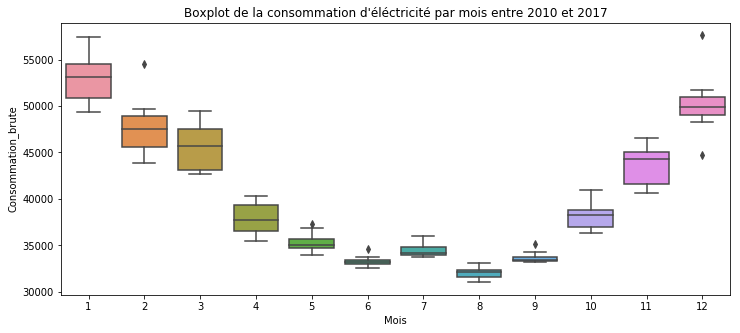

In [268]:
fig, ax = plt.subplots(figsize=(12,5))
sns.boxplot(eco.index.month, eco.Consommation_brute, ax=ax)
ax.set_title("Boxplot de la consommation d'éléctricité par mois entre 2010 et 2017")

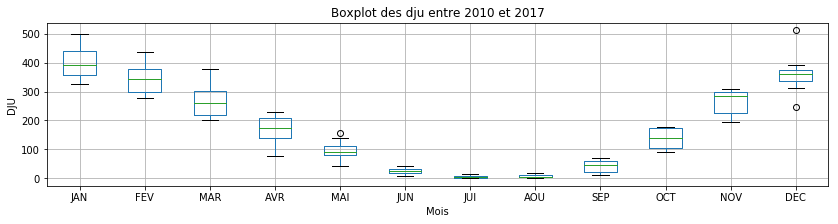

In [269]:
dju.drop(columns="ANNEE").boxplot(figsize=(14,3))
plt.title("Boxplot des dju entre 2010 et 2017")
plt.xlabel("Mois")
plt.ylabel("DJU")
plt.show()

In [270]:
# Correction de l'effet température par régression linéaire

In [271]:
i=0
j=0
A=[]
for j in range(0,8,1):
    for i in dju.drop(columns="ANNEE").columns :
        A.append(dju[i].loc[j])
        
A=A[0:96]

In [272]:
df_dju=pd.DataFrame({"Mois":eco1.Mois,"dju":A})
df_dju=df_dju.set_index("Mois")
print(df_dju.head())

              dju
Mois             
2010-01-01  499.2
2010-02-01  371.4
2010-03-01  294.5
2010-04-01  165.3
2010-05-01  140.9


In [273]:
# Régression linéaire

In [274]:
y = eco.Consommation_brute.copy()
X = df_dju.copy()
X = sm.add_constant(X)

In [275]:
results=sm.OLS(y,X).fit()
results.params

const    31831.938004
dju         48.564302
dtype: float64

In [276]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     Consommation_brute   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     2039.
Date:                Thu, 18 Apr 2019   Prob (F-statistic):           1.59e-65
Time:                        15:35:27   Log-Likelihood:                -839.84
No. Observations:                  96   AIC:                             1684.
Df Residuals:                      94   BIC:                             1689.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.183e+04    247.202    128.769      0.000    3.13e+04    3.23e+04
dju           48.5643      1.076     45.151      0.000      46.429      50.700
==============================================================================
Omnibus:                        0.217   Durbin-Watson:                   1.836
Prob(Omnibus):                  0.897   Jarque-Bera (JB):                0.294
Skew:                           0.109   Prob(JB):                        0.863
Kurtosis:                       2.839   Cond. No.                         361.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

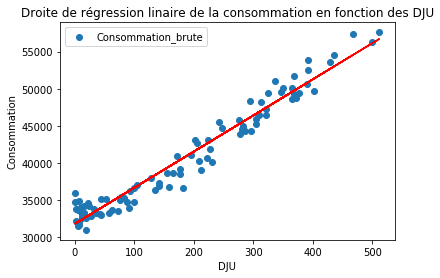

In [277]:
plt.scatter(df_dju,eco.Consommation_brute)
plt.plot(df_dju,results.predict(),color="red")
plt.xlabel("DJU")
plt.ylabel("Consommation")
plt.legend()
plt.title("Droite de régression linaire de la consommation en fonction des DJU")
plt.show()

In [278]:
#Calcul des résidus
pred_val = results.fittedvalues.copy()
residual = y - pred_val

In [279]:
# Hypothèse H0 : Il n'y a pas autocorrélation des résidus

sms.durbin_watson(residual)

# Résultat proche de 2. On ne peut donc pas rejetter l'hypothèse
#Il n'y a donc pas autocorrélation des résidus

1.835666911760647

Text(0.5, 1.0, 'Projection des résidus')

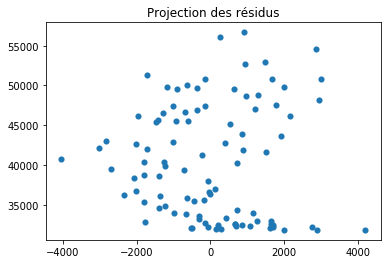

In [280]:
fig, ax = plt.subplots()
ax.scatter(residual, pred_val,linewidths=0.1)
plt.title("Projection des résidus")

In [281]:
# Hypothèse H0 : Les résidus et les les variables exogènes ont la même variance

sms.het_goldfeldquandt(results.resid, results.model.exog)

# La P-value est supérieure au seuil de 5%. L'Homostédasticité est donc acceptée.

(0.9648797314741909, 0.5479881595271596, 'increasing')

Text(0.5, 1.0, 'Graphique de probabilité des résidus')

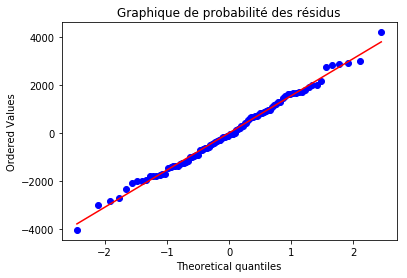

In [282]:
st.probplot(residual, plot= plt)
plt.title("Graphique de probabilité des résidus")

In [283]:
#Hypothèse H0 : les résidus suivent une distribution gaussienne

sms.jarque_bera(residual)[:2]

#La p-value est supérieure au seuil de 5%. On ne rejette donc pas l'hypothèse H0.
#La distribution des résidus est gaussienne

(0.2940991425845843, 0.8632511838789051)

In [284]:
#Correction des valeurs en soustrayant le coef*dju

df_dju["coef"]=results.params[1]
df_dju["correction"]=df_dju.dju*df_dju.coef
print(df_dju.head())
conso_corrige=pd.DataFrame(eco.Consommation_brute-(df_dju.correction))

              dju       coef    correction
Mois                                      
2010-01-01  499.2  48.564302  24243.299331
2010-02-01  371.4  48.564302  18036.781594
2010-03-01  294.5  48.564302  14302.186805
2010-04-01  165.3  48.564302   8027.679045
2010-05-01  140.9  48.564302   6842.710088


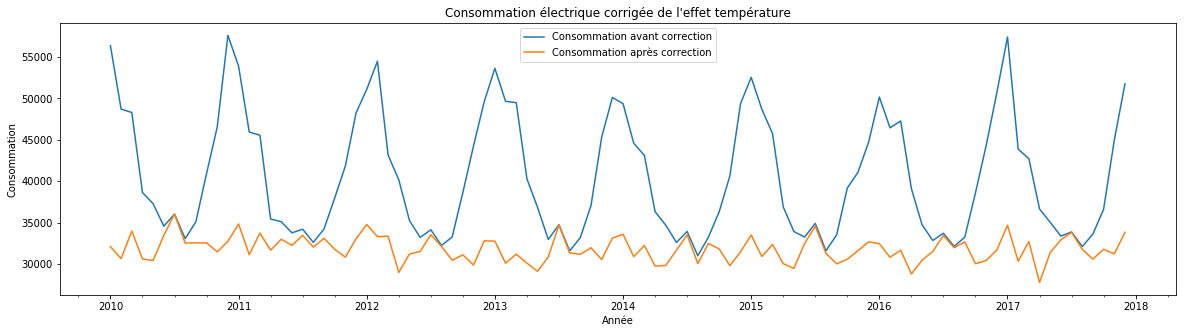

In [285]:
pd.merge(eco,conso_corrige,how="left",left_index=True,right_index=True).rename(columns={"Consommation_brute":"Consommation avant correction",0:"Consommation après correction"}).plot(figsize=(20,5))
plt.title("Consommation électrique corrigée de l'effet température")
plt.ylabel("Consommation")
plt.xlabel("Année")
plt.show()
#On a enlevé 95% de la variance, on a donc une courbe qui varie peu

In [286]:
#Moyennes mobiles

In [287]:
conso_corrige=conso_corrige.rename(columns={0:"consommation_corrigée"})

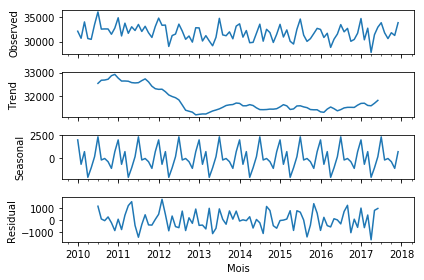

In [288]:
decomp_eco = seasonal_decompose(conso_corrige,  model='additive')
decomp_eco.plot()
plt.show()

In [289]:
MM=conso_corrige.copy()
MM["Moyenne_mobile"]=MM12(conso_corrige)
MM=MM.drop(columns={"consommation_corrigée"})

Text(0.5, 1.0, "Représentation de la consommation corrigée de l'effet température ainsi que de la moyenne mobile")

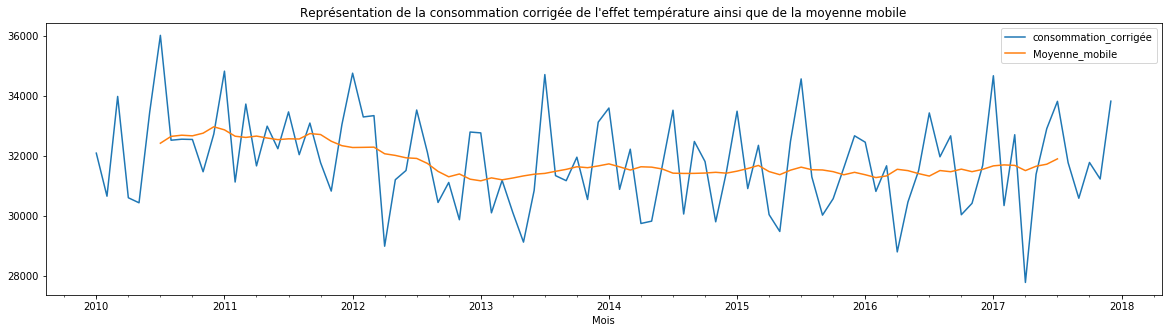

In [290]:
pd.merge(conso_corrige,MM,how="left",left_index=True,right_index=True).plot(figsize=(20,5))
plt.title("Représentation de la consommation corrigée de l'effet température ainsi que de la moyenne mobile")

In [291]:
#Calculer conso_corrige - Moyenne__Mobile

MECO=(conso_corrige["consommation_corrigée"]-MM["Moyenne_mobile"]).dropna()
MECO=MECO.reset_index()
print(MECO.head())

        Mois            0
0 2010-07-01  3600.651283
1 2010-08-01  -128.503558
2 2010-09-01  -133.801322
3 2010-10-01  -121.428169
4 2010-11-01 -1288.263026


In [292]:
# Calcul des coefficients saisonniers

MECO2=MECO.copy()
MECO2["Mois"]=MECO.Mois.dt.month
MECO2["Mois"]=pd.to_numeric(MECO2["Mois"])
MECO3=MECO2.groupby("Mois").mean()
z=MECO3.mean()

In [293]:
A=[]
for i in MECO3.index :
    A.append(MECO3.loc[i]-z)
print(pd.DataFrame(A))

              0
0   1995.023995
1   -708.157757
2    691.404412
3  -2155.963508
4  -1096.670852
5    150.531727
6   2306.025664
7   -227.666062
8    -68.440359
9   -429.647095
10 -1150.099125
11   693.658960


In [294]:
A=pd.DataFrame(A)
B=[]
for i in range(96) :
    B.append(float(conso_corrige.reset_index().loc[i][1]-A.loc[i%12]))


In [295]:
conso_mm=conso_corrige.copy()
conso_mm["Corrige"]=B
conso_mm=conso_mm.rename(columns={"Corrige":"consommation_desaisonnalise"})
conso_desaisonnalise=conso_corrige.drop(columns="consommation_corrigée")

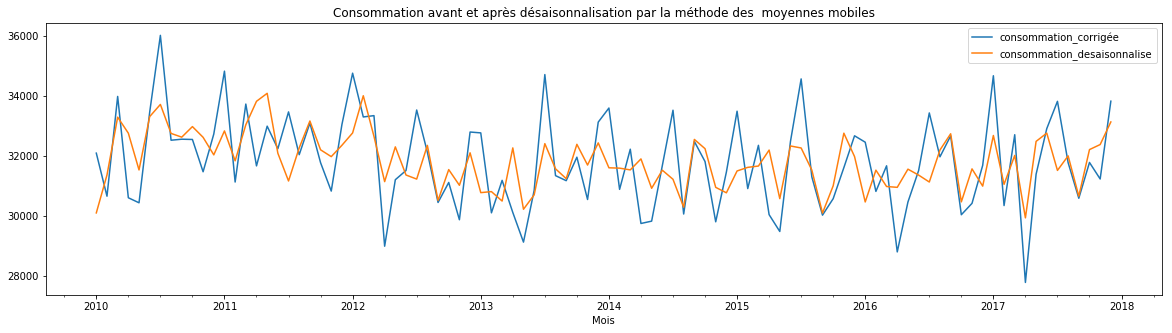

In [296]:
conso_mm.plot(figsize=(20,5))
plt.title("Consommation avant et après désaisonnalisation par la méthode des  moyennes mobiles")
plt.show()

In [297]:
# Lissage exponentiel ( Holt Winters )

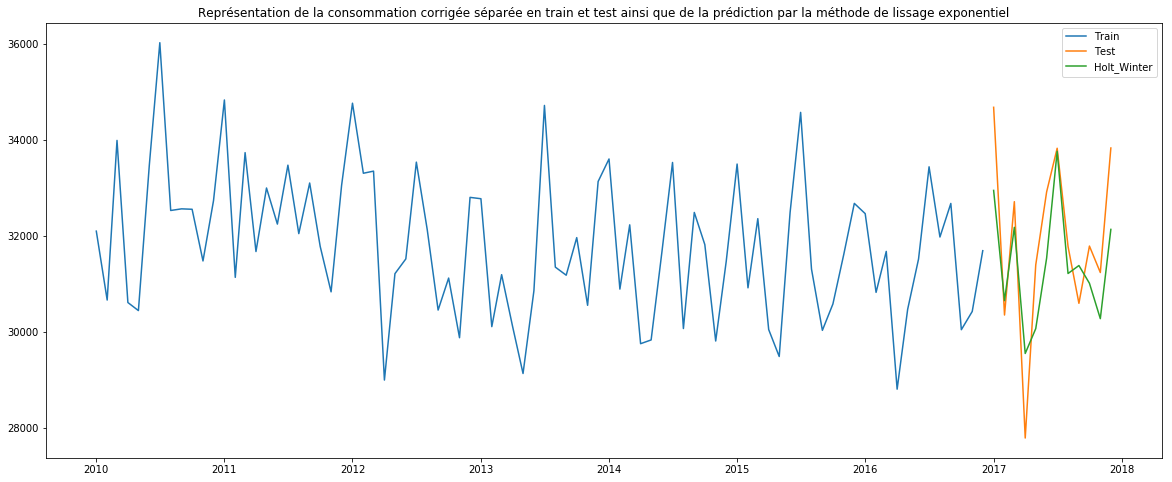

In [298]:
test = conso_corrige.consommation_corrigée.reset_index()[conso_corrige.consommation_corrigée.reset_index()["Mois"]>"2016-12-01"].set_index("Mois")
y_hat_avg = test.copy()
train = conso_corrige.consommation_corrigée.reset_index()[conso_corrige.consommation_corrigée.reset_index()["Mois"]<"2017-01-01"].set_index("Mois")
fit1 = ExponentialSmoothing(np.asarray(train) ,seasonal_periods=12 ,trend='add', seasonal='add',).fit()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(test))
plt.figure(figsize=(20,8))
plt.plot( train, label='Train')
plt.plot(test, label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.title("Représentation de la consommation corrigée séparée en train et test ainsi que de la prédiction par la méthode de lissage exponentiel")
plt.legend(loc='best')
plt.show()

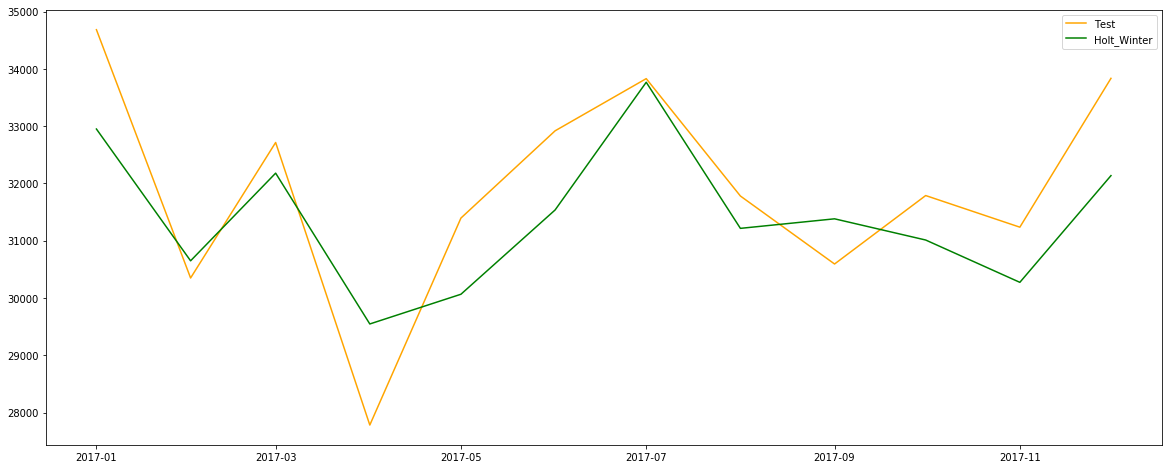

In [299]:
plt.figure(figsize=(20,8))
plt.plot(test, label='Test',color="orange")
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter',color="green")
plt.legend(loc='best')
plt.show()

In [300]:
HW_residuals=pd.DataFrame(y_hat_avg["Holt_Winter"]-test["consommation_corrigée"])
HW_residuals=HW_residuals.rename(columns={0:"Résidus"})

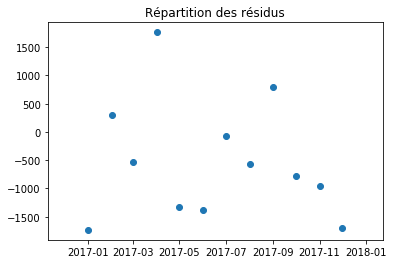

In [301]:
plt.scatter(HW_residuals.index,HW_residuals)
plt.title("Répartition des résidus")
plt.show()

In [302]:
# Test de normalité des résidus

# H0 : Les résidus suivent un distribution gaussienne.
st.kstest(HW_residuals,'norm')
# La p-value est au dessus du seuil de 5%, on ne rejette donc pas l'hypothèse H0.
# Les résidus ne suivent donc pas une distribution gaussienne.

KstestResult(statistic=1.0, pvalue=0.0)

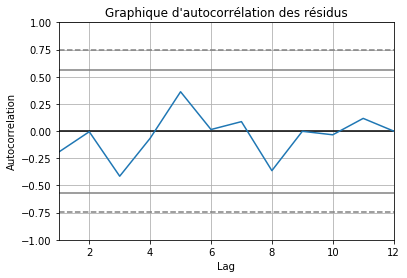

In [303]:
autocorrelation_plot(HW_residuals)
plt.title("Graphique d'autocorrélation des résidus")
plt.show()

In [304]:
# Test d'autocorrélation des résidus

# H0 : Il n'y a pas d'autocorrélation des résidus

stt.durbin_watson(HW_residuals)

# Le résultat est relativement proche de 2. On ne rejette donc pas l'hypothèse.
# Il n'y a pas d'autocorrélation des résidus

array([1.70904854])

In [305]:
rmse = sqrt(mean_squared_error(test, y_hat_avg.Holt_Winter))
print(rmse)

1137.617095794952


In [306]:
# SARIMA

In [307]:
#1. Check stationnarité

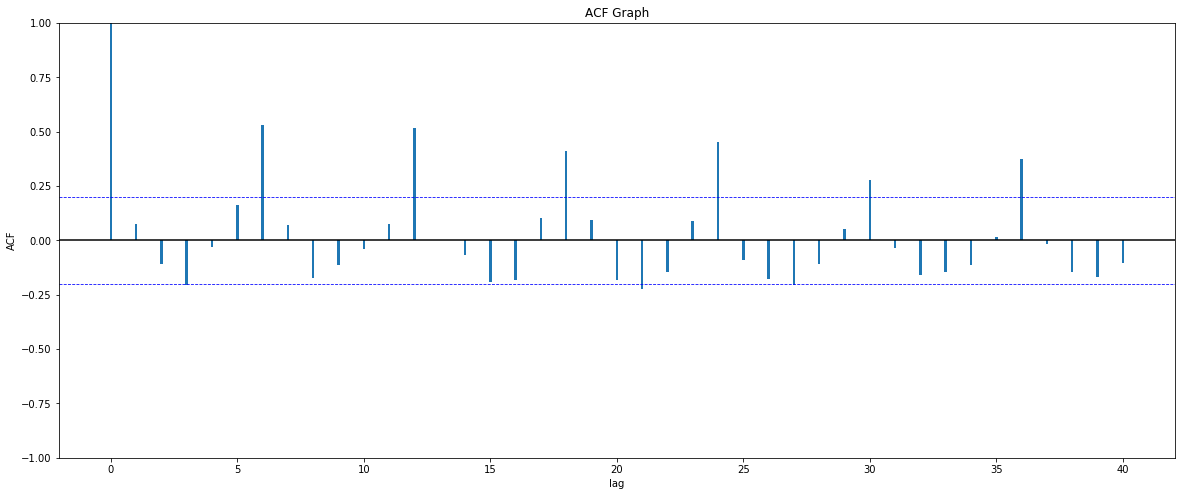

In [308]:
y_len = len(conso_corrige['consommation_corrigée'])

plot_sortie_acf(acf(np.asarray(conso_corrige['consommation_corrigée'])), y_len)

In [309]:
#H0 : Le série n'est pas stationnaire

result = adfuller(conso_corrige['consommation_corrigée'].values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# P-value supérieure au seuil de 5%. On ne rejette donc pas l'hypothèse
# La série n'est donc pas stationnaire

ADF Statistic: -1.6335919275061672
p-value: 0.465611120173586
Critial Values:
   1%, -3.510711795769895
Critial Values:
   5%, -2.8966159448223734
Critial Values:
   10%, -2.5854823866213152


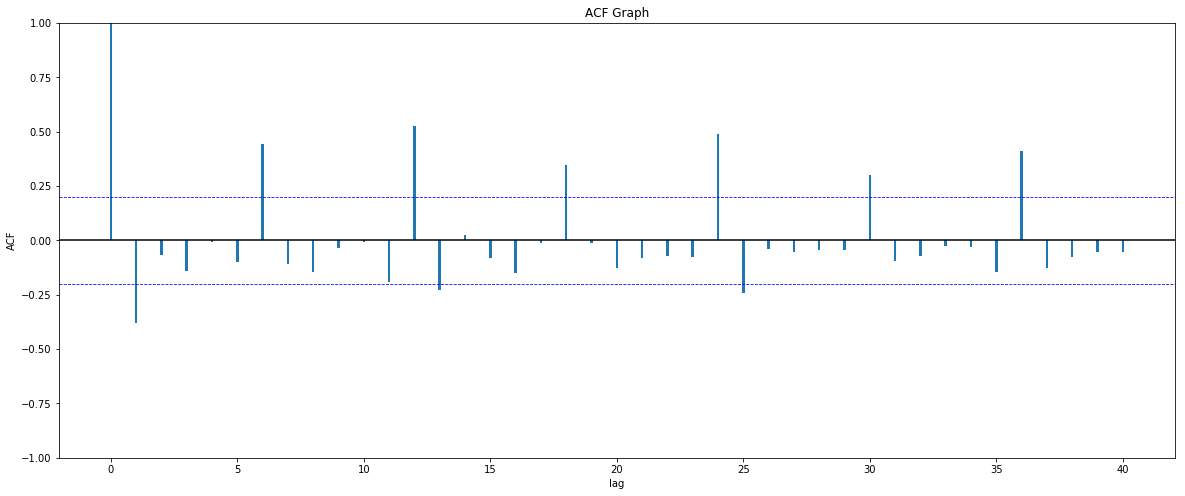

In [310]:
y_dif1=difference(conso_corrige['consommation_corrigée'].values, 1)

plot_sortie_acf(acf(np.asarray(y_dif1[1:])), y_len)

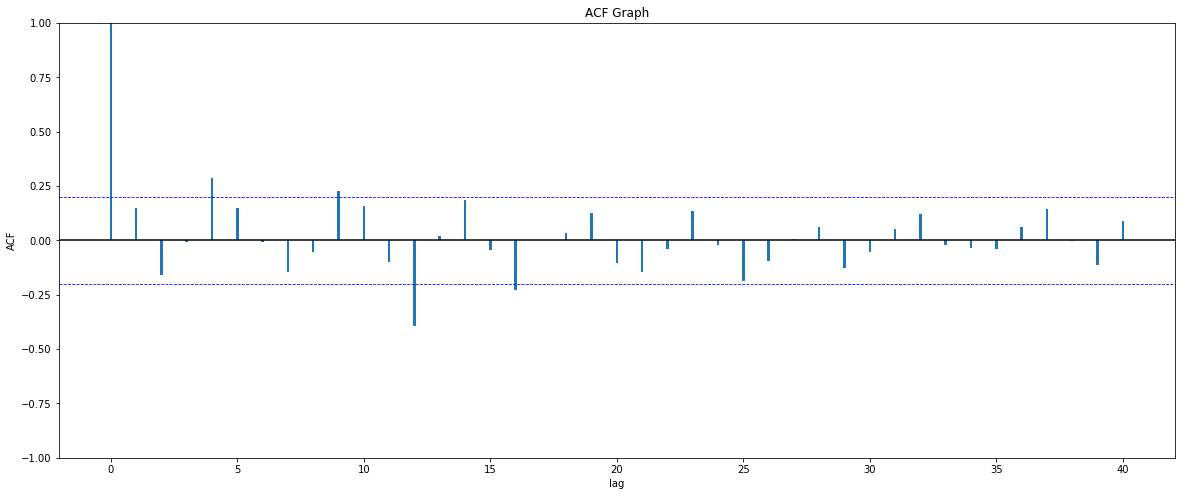

In [311]:
y_dif12=difference(conso_corrige['consommation_corrigée'].values, 12)

plot_sortie_acf(acf(np.asarray(y_dif12)), y_len)

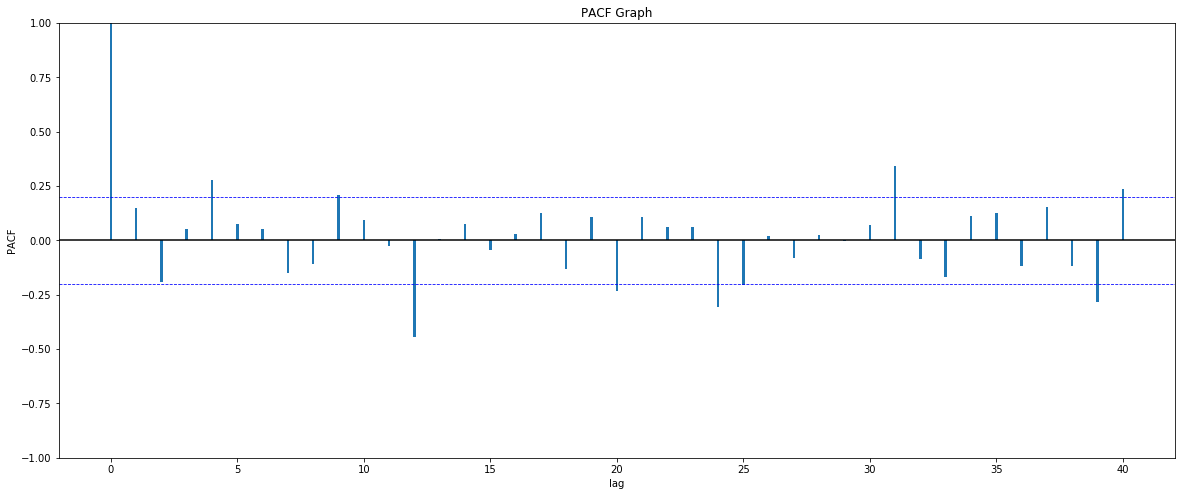

In [312]:
plot_sortie_acf(pacf(np.asarray(y_dif12)), y_len,pacf=True)

In [313]:
conso_corrige=conso_corrige.rename(columns={"consommation_corrigée":"Consommation_corrigée"})

In [314]:
# 2 identification, estimmation et vérification des modèles potentiels

In [315]:
model = SARIMAX(np.asarray(conso_corrige["Consommation_corrigée"]), order=(1,0,1), seasonal_order=(2,1,1,12))
results = model.fit()
print(results.summary())

print('Retard : p-value')
for elt in [6, 12, 18, 24, 30, 36]:
    print('{} : {}'.format(elt, acorr_ljungbox(results.resid, lags=elt)[1].mean()))

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                   96
Model:             SARIMAX(1, 0, 1)x(2, 0, 1, 12)   Log Likelihood                -825.788
Date:                            Thu, 18 Apr 2019   AIC                           1663.576
Time:                                    15:35:32   BIC                           1678.962
Sample:                                         0   HQIC                          1669.795
                                             - 96                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000   7.09e-05   1.41e+04      0.000       1.000       1.000
ma.L1         -0.9983      0.034   

In [316]:
# Test d'un autre modèle

In [317]:
model3 = SARIMAX(np.asarray(conso_corrige["Consommation_corrigée"]), order=(1,0,1), seasonal_order=(1,1,1,12))
results3 = model3.fit()
print(results3.summary())

print('Retard : p-value')
for elt in [6, 12, 18, 24, 30, 36]:
    print('{} : {}'.format(elt, acorr_ljungbox(results3.resid, lags=elt)[1].mean()))

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                   96
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                -816.707
Date:                            Thu, 18 Apr 2019   AIC                           1643.415
Time:                                    15:35:32   BIC                           1656.236
Sample:                                         0   HQIC                          1648.597
                                             - 96                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000   6.76e-06   1.48e+05      0.000       1.000       1.000
ma.L1         -0.9953      0.017   

C:\Users\Lucas\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [318]:
residuals=pd.DataFrame(results3.resid)[1:] # Premier facteur source d'erreur

In [319]:
# Tests sur les résidus du modèle SARIMA

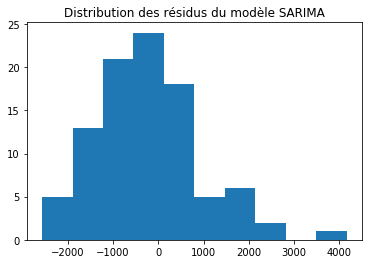

In [320]:
plt.hist(results3.resid[1:])
plt.title("Distribution des résidus du modèle SARIMA")
plt.show()

In [321]:
# Test de normalité des résidus

# H0 : Les résidus suivent un distribution gaussienne.
st.kstest(residuals,'norm')
# La p-value est inférieure du seuil de 5%, on rejette donc l'hypothèse H0.
# Les résidus ne suivent donc pas une distribution gaussienne.

KstestResult(statistic=1.0, pvalue=0.0)

In [322]:
# Test d'autocorrélation des résidus

# H0 : Il n'y a pas d'autocorrélation des résidus

stt.durbin_watson(residuals)

# Le résultat est relativement proche de 2. On ne rejette donc pas l'hypothèse.
# Il n'y a pas d'autocorrélation des résidus

array([1.63224371])

In [323]:
#Prévision avec le deuxième modéle

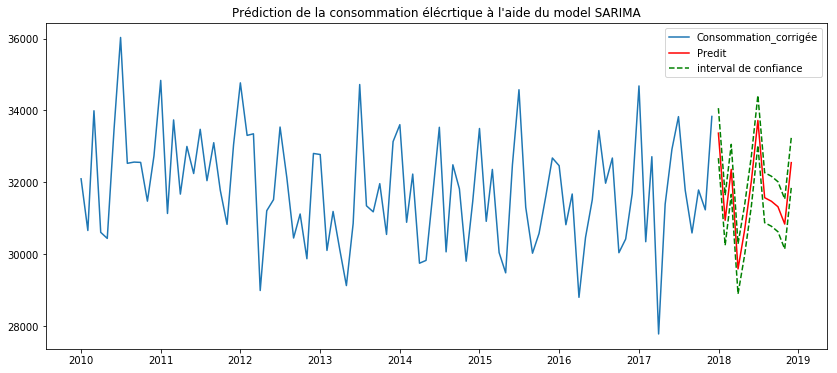

In [324]:
pred_model3 = results3.get_forecast(12)
pred = pred_model3.predicted_mean
pred_l = [elt[0] for elt in pred_model3.conf_int(alpha=0.5)]
pred_u = [elt[1] for elt in pred_model3.conf_int(alpha=0.5)]

plt.figure(figsize=(14,6))
plt.plot(conso_corrige["Consommation_corrigée"], label='Consommation_corrigée')
plt.plot(pd.date_range(conso_corrige.index[len(conso_corrige)-1], periods=12, freq='M'), pred, color='r', label='Predit')
plt.plot(pd.date_range(conso_corrige.index[len(conso_corrige)-1], periods=12, freq='M'), pred_l, color='g', linestyle='--',label="interval de confiance")
plt.plot(pd.date_range(conso_corrige.index[len(conso_corrige)-1], periods=12, freq='M'), pred_u, color='g', linestyle='--')
plt.title("Prédiction de la consommation élécrtique à l'aide du model SARIMA")
plt.legend()
plt.show()

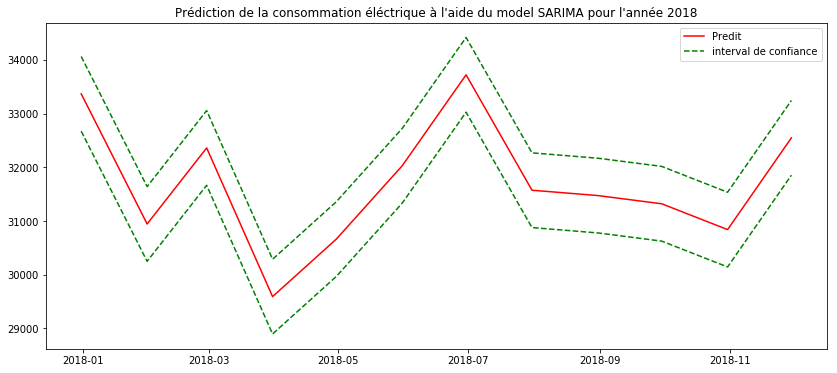

In [325]:
plt.figure(figsize=(14,6))
plt.plot(pd.date_range(conso_corrige.index[len(conso_corrige)-1], periods=12, freq='M'), pred, color='r', label='Predit')
plt.plot(pd.date_range(conso_corrige.index[len(conso_corrige)-1], periods=12, freq='M'), pred_l, color='g', linestyle='--',label="interval de confiance")
plt.plot(pd.date_range(conso_corrige.index[len(conso_corrige)-1], periods=12, freq='M'), pred_u, color='g', linestyle='--')
plt.legend()
plt.title("Prédiction de la consommation éléctrique à l'aide du model SARIMA pour l'année 2018")
plt.show()

In [326]:
#Analyse à postériori

In [327]:
y_tronc = conso_corrige[:'2016']
x_a_prevoir = conso_corrige['2017':]

print(y_tronc.head())
print(x_a_prevoir.head())

            Consommation_corrigée
Mois                             
2010-01-01           32098.700669
2010-02-01           30661.218406
2010-03-01           33991.813195
2010-04-01           30609.320955
2010-05-01           30441.289912
            Consommation_corrigée
Mois                             
2017-01-01           34682.763307
2017-02-01           30348.698450
2017-03-01           32713.897452
2017-04-01           27782.158538
2017-05-01           31394.677384


In [328]:
model3tronc = SARIMAX(np.asarray(y_tronc['Consommation_corrigée']), order=(1,0,1), seasonal_order=(1,1,1,12))
results3tronc = model3tronc.fit()
print(results3tronc.summary())

print('Retard : p-value')
for elt in [6, 12, 18, 24, 30, 36]:
    print('{} : {}'.format(elt, acorr_ljungbox(results3tronc.resid, lags=elt)[1].mean()))

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                   84
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                -717.231
Date:                            Thu, 18 Apr 2019   AIC                           1444.461
Time:                                    15:35:33   BIC                           1456.615
Sample:                                         0   HQIC                          1449.347
                                             - 84                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000   6.23e-05   1.61e+04      0.000       1.000       1.000
ma.L1         -0.9989      0.064   

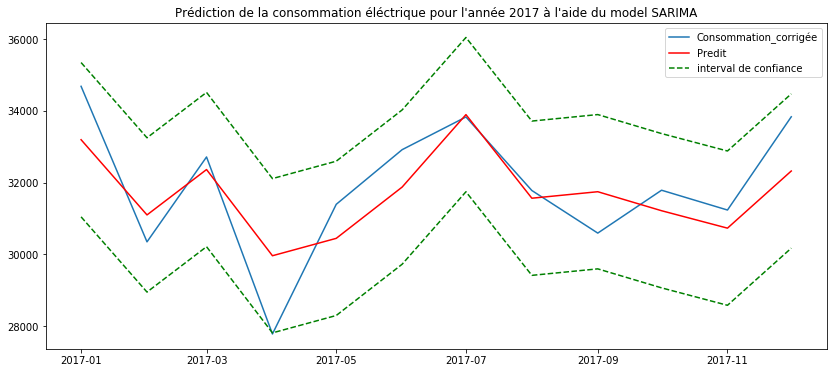

In [329]:
pred_model3tronc = results3tronc.get_forecast(12)
pred_tronc = pred_model3tronc.predicted_mean
pred_l_tronc = [elt[0] for elt in pred_model3tronc.conf_int(alpha=0.05)]
pred_u_tronc = [elt[1] for elt in pred_model3tronc.conf_int(alpha=0.05)]

plt.figure(figsize=(14,6))
plt.plot(x_a_prevoir, label='Consommation_corrigée')
plt.plot(x_a_prevoir.index, pred_tronc, color='r', label='Predit')
plt.plot(x_a_prevoir.index, pred_l_tronc, color='g', linestyle='--',label="interval de confiance")
plt.plot(x_a_prevoir.index, pred_u_tronc, color='g', linestyle='--')
plt.title("Prédiction de la consommation éléctrique pour l'année 2017 à l'aide du model SARIMA")
plt.legend()
plt.show()

In [330]:
#Root mean square error
rmse = np.sqrt(((x_a_prevoir['Consommation_corrigée']-pred_tronc)**2).mean())
rmse

1075.4749812116797